In [19]:
import pandas as pd
import folium
import numpy as np
import os
import warnings
from IPython.display import Image, display
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Geographic visualization of redispatch data for each day 

In [20]:
df_redispatch = pd.read_csv('data/output/geo_redispatch_data.csv')
df_redispatch = df_redispatch[df_redispatch['GRUND_DER_MASSNAHME'] == 'Strombedingter Redispatch']
days = df_redispatch['BEGINN_DATUM'].unique()

translation = {'Wirkleistungseinspeisung reduzieren': 'downward', 'Wirkleistungseinspeisung erhöhen': 'upward', 'Wirkleistungseinspeisung erh¿hen': 'upward',
               'Erneuerbar': 'RES', 'Konventionell': 'conventional', 'Sonstiges': 'others'}

#### Unit information

We first create a map that shows each redispatched unit and some details in a popup.

In [21]:
output_folder = "data/maps/unit_info"
os.makedirs(output_folder, exist_ok=True) 

for day in days:
    germany_map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

    df_day = df_redispatch[(df_redispatch['BEGINN_DATUM'] == day) & (~df_redispatch['Latitude'].isna()) & (~df_redispatch['Longitude'].isna())]

    locations = [
        {"name": row['BETROFFENE_ANLAGE'], 
         "Latitude": row['Latitude'], 
         "Longitude": row['Longitude'],
         "Richtung": row['RICHTUNG'],
         "GESAMTE_ARBEIT_MWH": row['GESAMTE_ARBEIT_MWH'],
         "PRIMAERENERGIEART": row['PRIMAERENERGIEART']
         }
        for _, row in df_day.iterrows() 
    ]
    
    for loc in locations:
        popup_content = f"Unit: {loc['name']}<br>Direction: {translation.get(loc['Richtung'], loc['Richtung'])}<br>Quantity: {translation.get(loc['GESAMTE_ARBEIT_MWH'], loc['GESAMTE_ARBEIT_MWH'])} MWh<br>Type: {translation.get(loc['PRIMAERENERGIEART'], loc['PRIMAERENERGIEART'])}"
        folium.Marker(
            location=[loc["Latitude"], loc["Longitude"]],
            popup=folium.Popup(popup_content, max_width=300),
            icon=folium.Icon(color="blue", icon="info-sign"),
            # tooltip=f"{loc['name']}"
        ).add_to(germany_map)
    
    germany_map.save(f"data/maps/unit_info/{day}.html")

#### Unit information and type

We can extend the map by indicating the type of each unit (green: renewable, red: conventional).

In [22]:
output_folder = "data/maps/unit_type"
os.makedirs(output_folder, exist_ok=True) 

for day in days:
    germany_map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

    df_day = df_redispatch[(df_redispatch['BEGINN_DATUM'] == day) & (~df_redispatch['Latitude'].isna()) & (~df_redispatch['Longitude'].isna())]

    locations = [
        {"name": row['BETROFFENE_ANLAGE'], 
         "Latitude": row['Latitude'], 
         "Longitude": row['Longitude'],
         "Richtung": row['RICHTUNG'],
         "GESAMTE_ARBEIT_MWH": row['GESAMTE_ARBEIT_MWH'],
         "PRIMAERENERGIEART": row['PRIMAERENERGIEART']
         }
        for _, row in df_day.iterrows() 
    ]

    values = [float(loc['GESAMTE_ARBEIT_MWH'].replace(',', '.')) for loc in locations]
    min_val, max_val = np.min(values), np.max(values)

    for loc in locations:
        gesamt_arbeit = float(loc['GESAMTE_ARBEIT_MWH'].replace(',', '.'))  

        radius = 5 + (gesamt_arbeit - min_val) / (max_val - min_val) * (20 - 5)

        popup_content = f"Unit: {loc['name']}<br>Direction: {translation.get(loc['Richtung'], loc['Richtung'])}<br>Quantity: {translation.get(loc['GESAMTE_ARBEIT_MWH'], loc['GESAMTE_ARBEIT_MWH'])} MWh<br>Type: {translation.get(loc['PRIMAERENERGIEART'], loc['PRIMAERENERGIEART'])}"

        folium.CircleMarker(
            location=[loc["Latitude"], loc["Longitude"]],
            radius=radius,
            color="green" if loc['PRIMAERENERGIEART'] == "Erneuerbar" else "red",
            fill=True,
            fill_opacity=0.7,
            popup=folium.Popup(popup_content, max_width=300)  
        ).add_to(germany_map)
        
    germany_map.save(f"data/maps/unit_type/{day}.html")


Example for 31.12.2024:

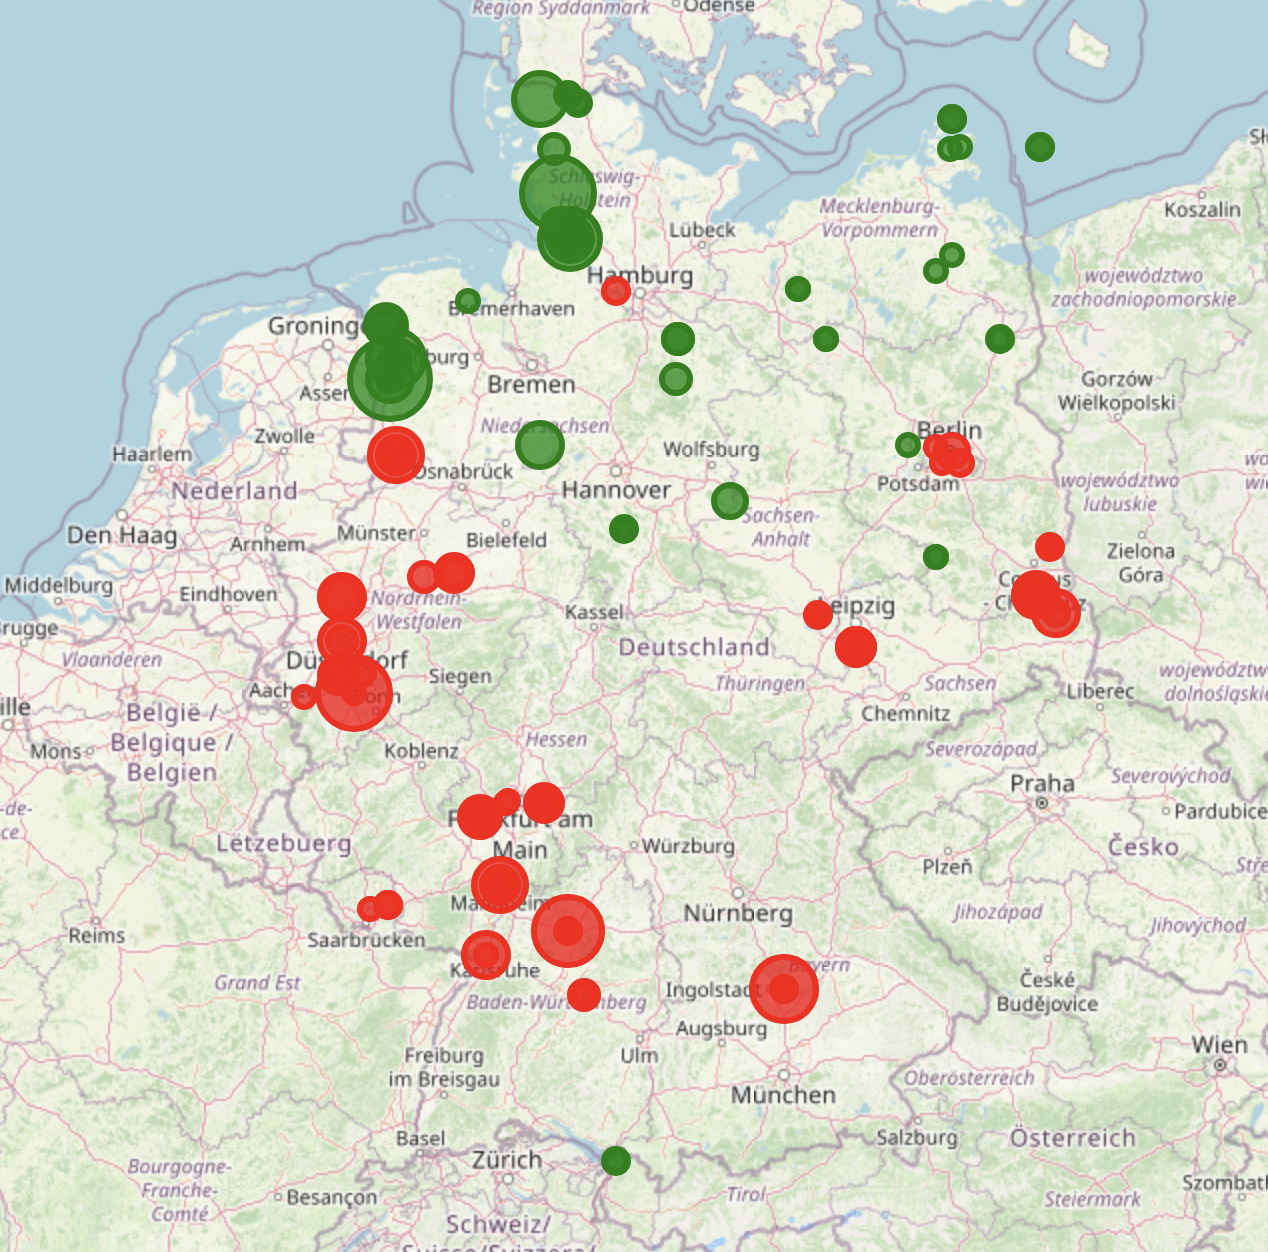

In [23]:
display(Image(filename='data/maps/examples/31.12.2024_type.png', width=500, height=700))

#### Redispatch direction

Alternatively, we can indicate whether the units was downward (blue) or upward (orange) redispatched.

In [24]:
output_folder = "data/maps/unit_direction"
os.makedirs(output_folder, exist_ok=True) 

for day in days:
    germany_map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

    df_day = df_redispatch[(df_redispatch['BEGINN_DATUM'] == day) & (~df_redispatch['Latitude'].isna()) & (~df_redispatch['Longitude'].isna())]

    locations = [
        {"name": row['BETROFFENE_ANLAGE'], 
         "Latitude": row['Latitude'], 
         "Longitude": row['Longitude'],
         "Richtung": row['RICHTUNG'],
         "GESAMTE_ARBEIT_MWH": row['GESAMTE_ARBEIT_MWH'],
         "PRIMAERENERGIEART": row['PRIMAERENERGIEART']
         }
        for _, row in df_day.iterrows() 
    ]

    values = [float(loc['GESAMTE_ARBEIT_MWH'].replace(',', '.')) for loc in locations]
    min_val, max_val = np.min(values), np.max(values)

    for loc in locations:
        gesamt_arbeit = float(loc['GESAMTE_ARBEIT_MWH'].replace(',', '.'))  
        radius = 5 + (gesamt_arbeit - min_val) / (max_val - min_val) * (20 - 5)

        popup_content = f"Unit: {loc['name']}<br>Direction: {translation.get(loc['Richtung'], loc['Richtung'])}<br>Quantity: {translation.get(loc['GESAMTE_ARBEIT_MWH'], loc['GESAMTE_ARBEIT_MWH'])} MWh<br>Type: {translation.get(loc['PRIMAERENERGIEART'], loc['PRIMAERENERGIEART'])}"

        folium.CircleMarker(
            location=[loc["Latitude"], loc["Longitude"]],
            radius=radius,
            color="orange" if loc['Richtung'] in ['Wirkleistungseinspeisung erhöhen', 'Wirkleistungseinspeisung erh¿hen'] else "blue",
            fill=True,
            fill_opacity=0.7,
            popup=folium.Popup(popup_content, max_width=300) 
        ).add_to(germany_map)
        
    germany_map.save(f"data/maps/unit_direction/{day}.html")


Example for 31.12.2024:

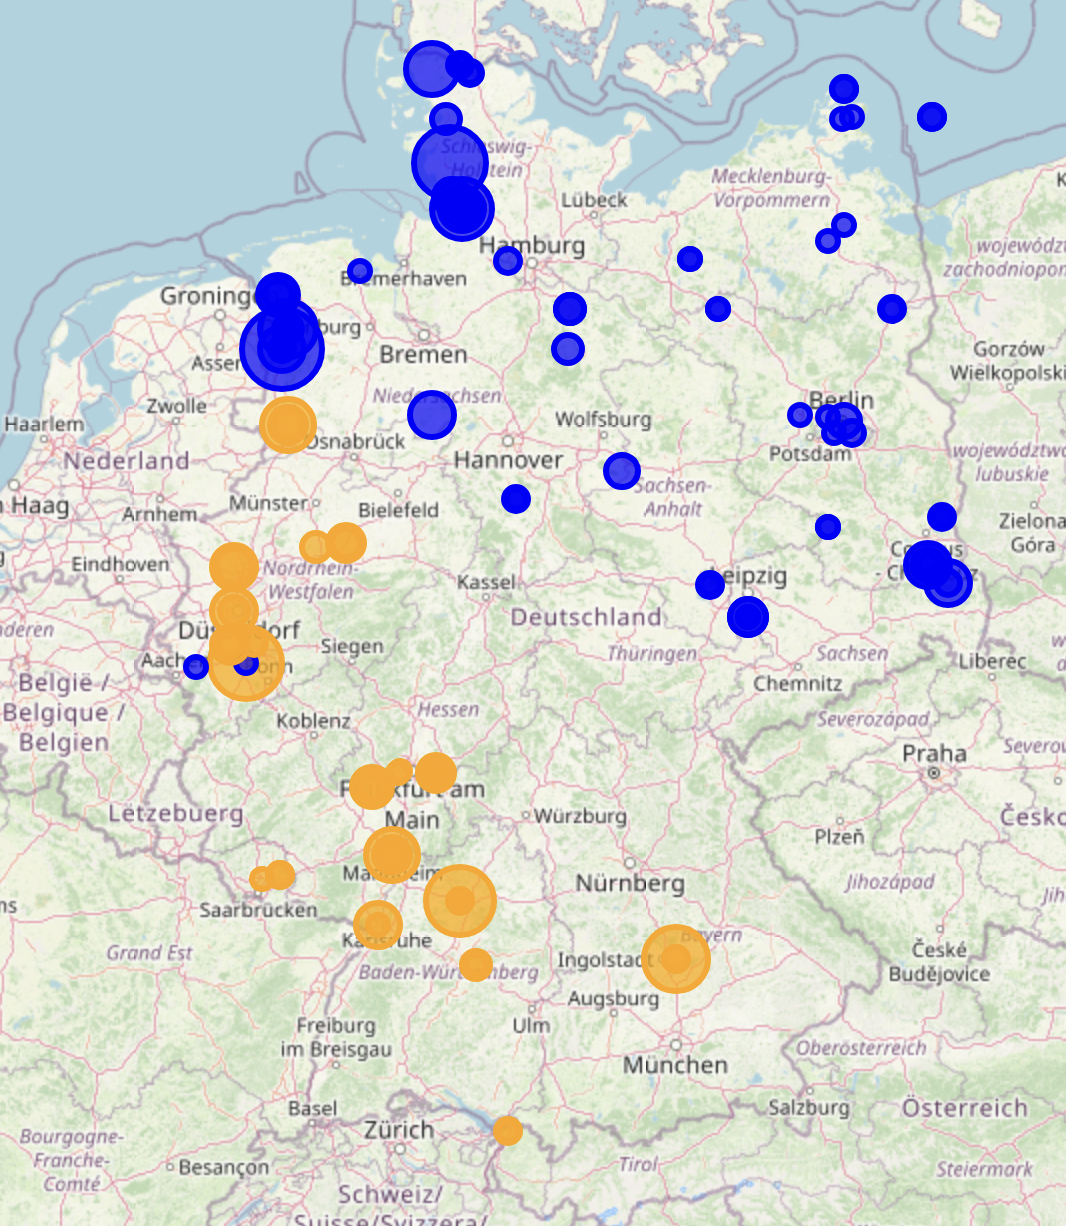

In [25]:
display(Image(filename='data/maps/examples/31.12.2024_direction.png', width=500, height=700))